[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tahamsi/computer-vision/blob/main/week-9/Image_segmentation_with_SAM_2.ipynb)

 [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/tahamsi/computer-vision)

# Image Segmentation with Segment Anything Model v2 (SAM 2)



[Segment Anything Model 2](https://github.com/facebookresearch/sam2?tab=readme-ov-file) (SAM 2) is a foundation model designed for promptable visual segmentation in both images and videos. To extend SAM's capabilities to video, individual images are treated as single-frame videos. The model utilizes a streamlined transformer architecture with a streaming memory component to enable real-time video processing. Trained on a large, diverse dataset, SAM 2 demonstrates strong performance across various tasks and visual domains.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-2-paper.jpg)

##Promptable Visial Segmentation
Promptable visual segmentation is a technique where a segmentation model, such as SAM 2, is guided by prompts to identify and segment specific parts of an image or video. Prompts can be various types of inputs, such as:

* Points: Locations in the image that indicate the starting position or an object to be segmented.
* Boxes: Bounding boxes around objects, helping the model understand the region of interest.
* Masks: Roughly defined regions, which the model can refine into more accurate segmentations.
* Text Prompts: In some models, text descriptions guide the segmentation to certain types of objects (e.g., “segment the dog” in an image with multiple animals).

The benefit of promptable segmentation is flexibility; users can direct the model to focus on specific areas or types of objects without pre-defined categories, making it adaptable for various tasks and contexts.



### Before you start

Let's ensure we have `GPU` access by using the `nvidia-smi` command to check. If there are any issues, go to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. The codes here are extended from [Meta AI](https://github.com/facebookresearch/sam2?tab=readme-ov-file) and [Roboflow](https://github.com/roboflow/notebooks).

In [ ]:
!nvidia-smi

Sat Nov  9 18:40:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Install SAM2

In [ ]:
import os
HOME = os.getcwd()
!git clone https://github.com/facebookresearch/sam2.git
%cd sam2
!pip install -e .

In [ ]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.2 MB/s eta 0:00:00


### Download checkpoints

SAM2 is available in four model sizes, ranging from the lightweight `sam2_hiera_tiny` with 38.9 million parameters to the more powerful `sam2_hiera_large` with 224.4 million parameters.

In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

### Download sample images

Download a few images from my repository, or feel free to use any other images you prefer.

### Imports

In [ ]:
!mkdir -p {HOME}/data
!wget https://raw.githubusercontent.com/tahamsi/computer-vision/refs/heads/main/images/peel.jpg -P {HOME}/data
!wget https://raw.githubusercontent.com/tahamsi/computer-vision/refs/heads/main/images/London_bridge.jpg -P {HOME}/data
!wget https://raw.githubusercontent.com/tahamsi/computer-vision/refs/heads/main/images/img-7.jpg -P {HOME}/data
!wget https://raw.githubusercontent.com/tahamsi/computer-vision/refs/heads/main/images/img-8.jpg -P {HOME}/data
!wget https://raw.githubusercontent.com/tahamsi/computer-vision/refs/heads/main/images/img-9.jpg -P {HOME}/data

--2024-11-09 19:07:17--  https://raw.githubusercontent.com/tahamsi/computer-vision/refs/heads/main/images/peel.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538364 (526K) [image/jpeg]
Saving to: ‘/content/data/peel.jpg’

peel.jpg            100%[===================>] 525.75K  --.-KB/s    in 0.01s   

2024-11-09 19:07:17 (50.5 MB/s) - ‘/content/data/peel.jpg’ saved [538364/538364]

--2024-11-09 19:07:17--  https://raw.githubusercontent.com/tahamsi/computer-vision/refs/heads/main/images/London_bridge.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting r

In [ ]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

This code enables `mixed-precision` computing to accelerate deep learning. It primarily uses bfloat16 for calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for specific operations to enhance performance further.

In [ ]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Load model





In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

## Automated mask generation

SAM 2 can efficiently process prompts, enabling the generation of masks for an entire image by sampling a large number of prompts across it.

The `SAM2AutomaticMaskGenerator` class implements this functionality by sampling single-point input prompts in a grid over the image. SAM then predicts multiple masks from each prompt. The masks are filtered for quality and deduplicated using NMS. Additional options allow further refinement of mask quality and quantity, such as running predictions on multiple crops of the image or postprocessing masks to remove small disconnected regions and fill holes.

In [ ]:
mask_generator = SAM2AutomaticMaskGenerator(model)

In [ ]:
IMAGE_PATH = f"{HOME}/data/img-8.jpg"


image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
result = mask_generator.generate(image_rgb)

### Output format

`SAM2AutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

### Results visualisation

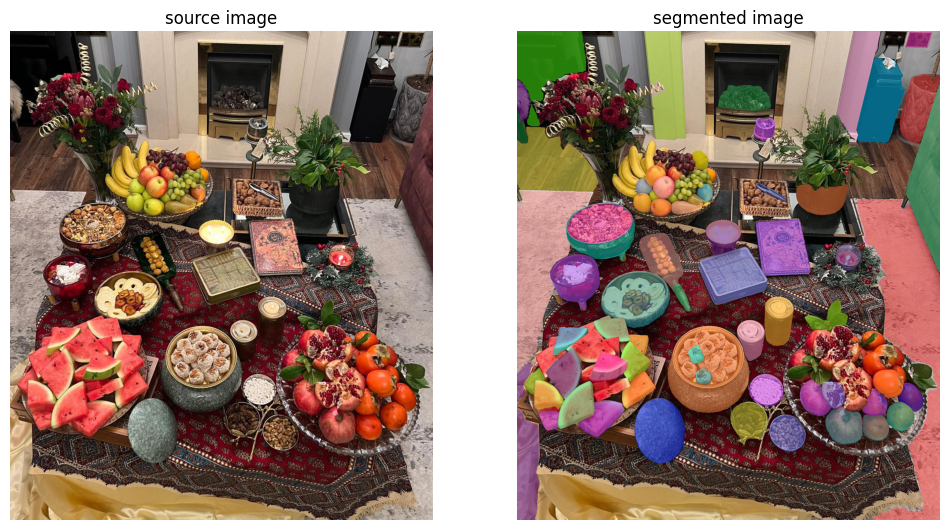

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

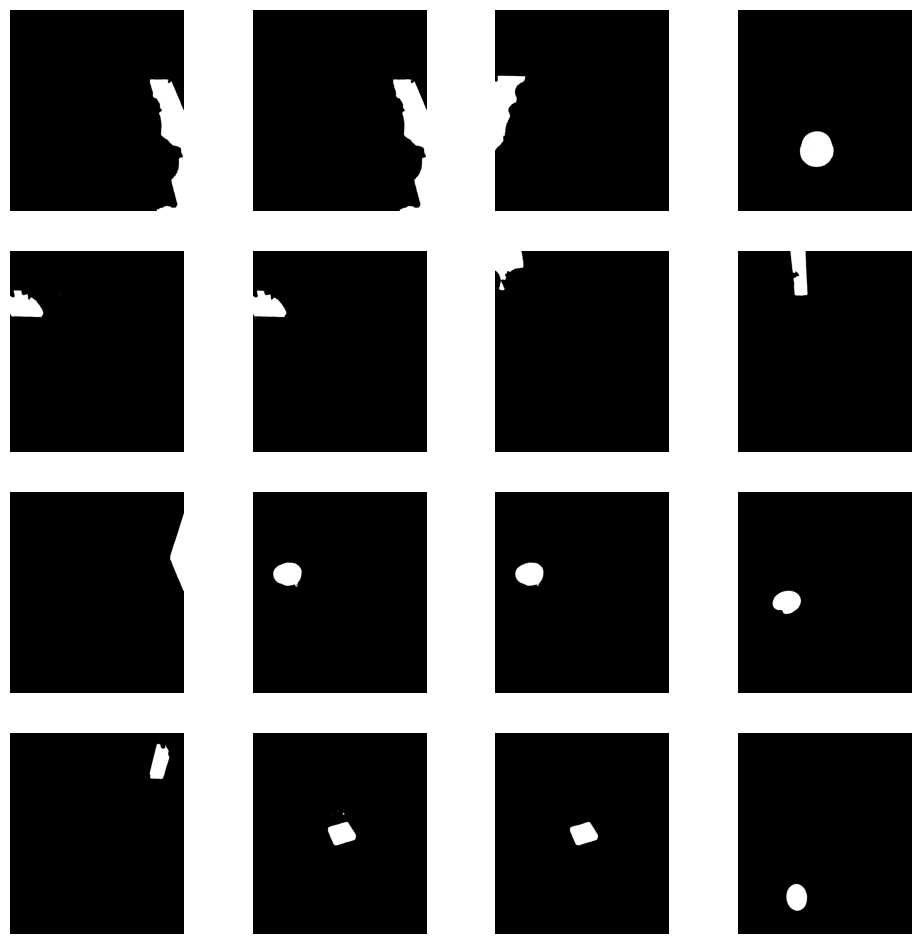

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

### Advanced automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes.

- `points_per_side` `[int or None]` - the number of points to be sampled
along one side of the image. The total number of points is
`points_per_side**2`. If `None`, `point_grids` must provide explicit
point sampling.
- `points_per_batch` - `[int]` - sets the number of points run simultaneously
by the model. Higher numbers may be faster but use more GPU memory.
- `pred_iou_thresh` `[float]` - a filtering threshold in `[0,1]`, using the
model's predicted mask quality.
- `stability_score_thresh` - `[float]` - a filtering threshold in `[0,1]`, using
the stability of the mask under changes to the cutoff used to binarize
the model's mask predictions.
- `stability_score_offset` - `[float]` - the amount to shift the cutoff when
calculated the stability score.
- `mask_threshold` - `[float]` - threshold for binarizing the mask logits
- `box_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks.
- `crop_n_layers` - `[int]` - if `>0`, mask prediction will be run again on
crops of the image. Sets the number of layers to run, where each
layer has `2**i_layer` number of image crops.
- `crop_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks between different crops.
- `crop_overlap_ratio` - `[float]` - sets the degree to which crops overlap.
In the first crop layer, crops will overlap by this fraction of
the image length. Later layers with more crops scale down this overlap.
- `crop_n_points_downscale_factor` - `[int]` - the number of points-per-side
sampled in layer `n` is scaled down by `crop_n_points_downscale_factor**n`.
- `point_grids` - `[List[np.ndarray] or None]` - a list over explicit grids
of points used for sampling, normalized to `[0,1]`. The nth grid in the
list is used in the nth crop layer. Exclusive with points_per_side.
- `min_mask_region_area` - `[int]` - if `>0`, postprocessing will be applied
to remove disconnected regions and holes in masks with area smaller
than `min_mask_region_area`. Requires opencv.

In [ ]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

In [ ]:
sam2_2 = mask_generator_2.generate(image_rgb)

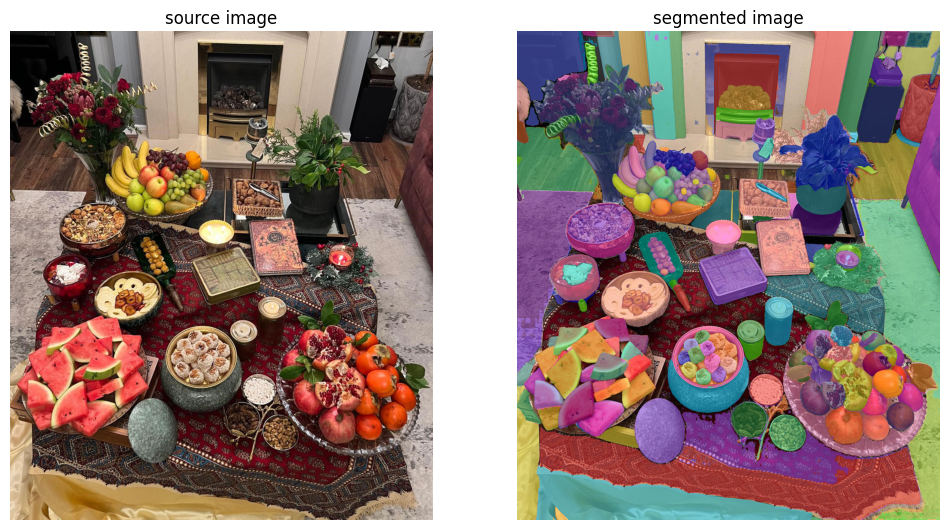

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_2)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## Prompting with boxes

The `SAM2ImagePredictor` class offers a simple interface for interacting with the model through prompts. Users can set an image using the `set_image` method, which computes the required image embeddings. Then, prompts can be supplied via the predict method to efficiently generate masks based on these prompts. The model accepts point and box prompts, as well as masks from previous prediction iterations.

In [ ]:
predictor = SAM2ImagePredictor(model)

In [ ]:
# Interactive box prompt
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

Run the cell below and use your mouse to draw a bounding box on the image.

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 138, 'y': 594, 'width': 142, 'height': 158, 'label': ''},
 {'x': 311, 'y': 850, 'width': 206, 'height': 144, 'label': ''}]

**NOTE:** `Sam2ImagePredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format.

In [ ]:
default_box = [
    {'x': 166, 'y': 835, 'width': 99, 'height': 175, 'label': ''},
    {'x': 472, 'y': 885, 'width': 168, 'height': 249, 'label': ''},
    {'x': 359, 'y': 727, 'width': 27, 'height': 155, 'label': ''},
    {'x': 164, 'y': 1044, 'width': 279, 'height': 163, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
boxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
])

### Generate masks with SAM

**NOTE:** Process the image to produce an image embedding by calling `SAM2ImagePredictor.set_image`. `SAM2ImagePredictor` remembers this embedding and will use it for subsequent mask prediction. `SAM2ImagePredictor.predict` takes the following arguments:

- `point_coords` - `[np.ndarray or None]` - a `Nx2` array of point prompts to the model. Each point is in `(X,Y)` in pixels.
- `point_labels` - `[np.ndarray or None]` - a length `N` array of labels for the
point prompts. `1` indicates a foreground point and `0` indicates a
background point.
- `box` - `[np.ndarray or None]` - a length `4` array given a box prompt to the
model, in `[x_min, y_min, x_max, y_max]` format.
- `mask_input` - `[np.ndarray]` - a low resolution mask input to the model, typically coming from a previous prediction iteration. Has form `1xHxW`, where
for SAM, `H=W=256`.
- `multimask_output` - `[bool]` - if true, the model will return three masks.
For ambiguous input prompts (such as a single click), this will often
produce better masks than a single prediction. If only a single
mask is needed, the model's predicted quality score can be used
to select the best mask. For non-ambiguous prompts, such as multiple
input prompts, `multimask_output=False` can give better results.
- `return_logits` - `[bool]` - if true, returns un-thresholded masks logits
instead of a binary mask.
- `normalize_coords` - `[bool]` - if true, the point coordinates will be normalized to the range `[0,1]` and point_coords is expected to be wrt. image dimensions.

In [ ]:
predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)

masks = np.squeeze(masks)

### Results visualisation

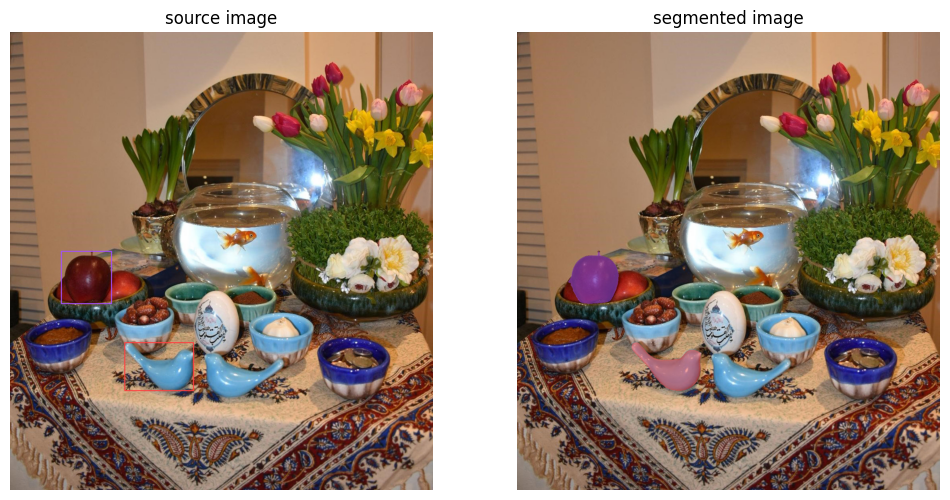

In [ ]:
box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## Prompting with points

Execute cell below and use your mouse to **draw points** on the image.

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 205, 'y': 670, 'width': 0, 'height': 0, 'label': ''},
 {'x': 636, 'y': 566, 'width': 0, 'height': 0, 'label': ''}]

In [ ]:
default_box = [
    {'x': 330, 'y': 450, 'width': 0, 'height': 0, 'label': ''},
    {'x': 191, 'y': 665, 'width': 0, 'height': 0, 'label': ''},
    {'x': 86, 'y': 879, 'width': 0, 'height': 0, 'label': ''},
    {'x': 425, 'y': 727, 'width': 0, 'height': 0, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
])
input_label = np.ones(input_point.shape[0])

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True`, SAM 2 outputs three masks, with scores indicating the model’s estimation of each mask’s quality. This setting is designed for ambiguous input prompts, helping the model differentiate between possible objects matching the prompt. When set to `False`, the model returns a single mask. For ambiguous prompts, like a single point, it is recommended to keep `multimask_output=True` even if only one mask is needed; the best mask can then be selected by choosing the one with the highest score in scores, often yielding a more accurate result.

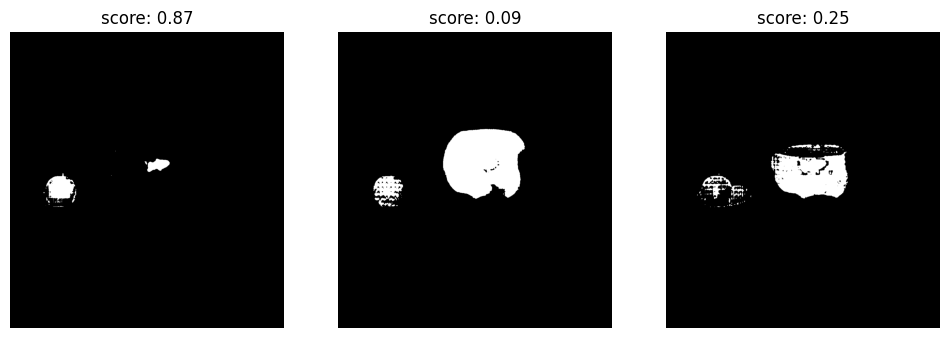

In [ ]:
sv.plot_images_grid(
    images=masks,
    titles=[f"score: {score:.2f}" for score in scores],
    grid_size=(1, 3),
    size=(12, 12)
)